In [12]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
!pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install scikit-learn joblib matplotlib seaborn

Using device: cuda:0
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import joblib
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors


In [14]:
# Data Load
data_path = '/kaggle/input/dataset/train_test_split.pkl'
data = joblib.load(data_path)

if isinstance(data, tuple):
    if len(data) == 4:
        train_embeddings, test_embeddings, train_labels, test_labels = data
    elif len(data) == 2:
        (train_embeddings, train_labels), (test_embeddings, test_labels) = data
elif isinstance(data, dict):
    train_embeddings = data['train_embeddings']
    train_labels = data['train_labels']
    test_embeddings = data['test_embeddings']
    test_labels = data['test_labels']

data_dict = {
    'train_embeddings': train_embeddings,
    'train_labels': train_labels,
    'test_embeddings': test_embeddings,
    'test_labels': test_labels
}

In [15]:
# Model Definition
class GNNReadabilityGAT(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256, num_classes=6, dropout=0.3):
        super(GNNReadabilityGAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=4, dropout=dropout)
        self.conv2 = GATConv(hidden_dim*4, hidden_dim, heads=4, dropout=dropout)
        self.conv3 = GATConv(hidden_dim*4, hidden_dim, heads=1, dropout=dropout)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.bn1 = nn.BatchNorm1d(hidden_dim*4)
        self.bn2 = nn.BatchNorm1d(hidden_dim*4)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)  # no edge_weight
        x = self.bn1(x)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = F.elu(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [16]:
# Graph Creation
def create_graph_from_embeddings(embeddings, labels, k=10):
    nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)
    
    row = np.repeat(np.arange(len(embeddings)), k)
    col = indices.flatten()
    edge_index = torch.tensor([row, col], dtype=torch.long)

    x = torch.tensor(embeddings, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)
    
    data = Data(x=x, edge_index=edge_index, y=y)
    print(f"Graph created: {data.num_nodes} nodes, {data.num_edges} edges")
    return data

In [17]:
# Training Functions
def train_epoch(model, data, optimizer, criterion, device):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, device):
    model.eval()
    data = data.to(device)
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        accuracy = (pred == data.y).sum().item() / len(data.y)
    return accuracy, pred.cpu()

def calculate_adjacency_accuracy(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred) <= 1) / len(y_true)

def calculate_qwk(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

Graph created: 32487 nodes, 324870 edges
Graph created: 4641 nodes, 46410 edges
Graph created: 9282 nodes, 92820 edges
Epoch 1: Loss=1.8177, Train Acc=0.2537, Val Acc=0.2504
Epoch 2: Loss=1.5580, Train Acc=0.3217, Val Acc=0.3191
Epoch 3: Loss=1.4744, Train Acc=0.4019, Val Acc=0.3894
Epoch 4: Loss=1.4026, Train Acc=0.4376, Val Acc=0.4327
Epoch 5: Loss=1.3533, Train Acc=0.4530, Val Acc=0.4525
Epoch 6: Loss=1.3241, Train Acc=0.4797, Val Acc=0.4738
Epoch 7: Loss=1.2979, Train Acc=0.4989, Val Acc=0.4949
Epoch 8: Loss=1.2805, Train Acc=0.5071, Val Acc=0.5016
Epoch 9: Loss=1.2711, Train Acc=0.5118, Val Acc=0.4977
Epoch 10: Loss=1.2564, Train Acc=0.5114, Val Acc=0.4992
Epoch 11: Loss=1.2432, Train Acc=0.5139, Val Acc=0.4986
Epoch 12: Loss=1.2385, Train Acc=0.5203, Val Acc=0.4964
Epoch 13: Loss=1.2307, Train Acc=0.5280, Val Acc=0.5033
Epoch 14: Loss=1.2234, Train Acc=0.5302, Val Acc=0.5038
Epoch 15: Loss=1.2168, Train Acc=0.5315, Val Acc=0.5074
Epoch 16: Loss=1.2044, Train Acc=0.5328, Val Acc=0

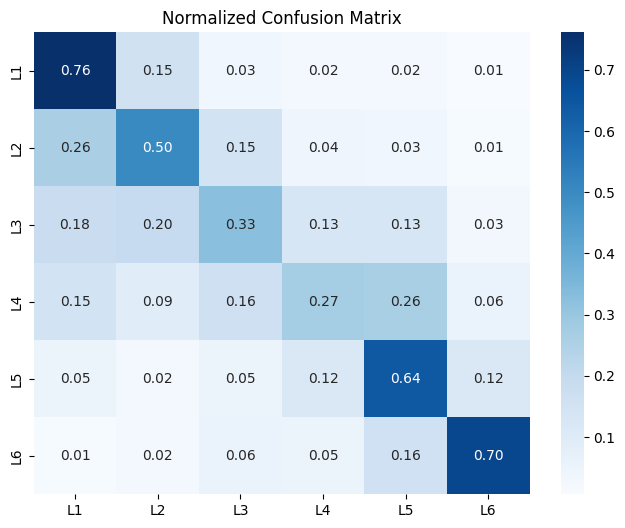

In [18]:
def main():
    train_embeddings = data_dict['train_embeddings']
    train_labels = data_dict['train_labels']
    val_ratio = 0.125

    train_emb, val_emb, train_lbl, val_lbl = train_test_split(
        train_embeddings, train_labels,
        test_size=val_ratio,
        random_state=42,
        stratify=train_labels
    )

    train_data = create_graph_from_embeddings(train_emb, train_lbl, k=10)
    val_data = create_graph_from_embeddings(val_emb, val_lbl, k=10)
    test_data = create_graph_from_embeddings(data_dict['test_embeddings'], data_dict['test_labels'], k=10)

    input_dim = train_emb.shape[1]
    model = GNNReadabilityGAT(input_dim=input_dim, hidden_dim=256, num_classes=6).to(device)
    train_data, val_data, test_data = train_data.to(device), val_data.to(device), test_data.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0
    patience = 15
    patience_counter = 0

    for epoch in range(50):
        loss = train_epoch(model, train_data, optimizer, criterion, device)
        train_acc, _ = evaluate(model, train_data, device)
        val_acc, _ = evaluate(model, val_data, device)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_gat_model.pt')
        else:
            patience_counter += 1

        print(f"Epoch {epoch+1}: Loss={loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    model.load_state_dict(torch.load('best_gat_model.pt'))
    test_acc, test_pred = evaluate(model, test_data, device)
    y_true = test_data.y.cpu().numpy()
    y_pred = test_pred.numpy()
    
    # ---- Classification report ----
    print("\nClassification Report")
    print(classification_report(y_true, y_pred, digits=4))
    # ---- Metrics ----
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    adj_acc = calculate_adjacency_accuracy(y_true, y_pred)
    qwk = calculate_qwk(y_true, y_pred)

    print(f"\nTest Acc: {test_acc:.4f}")
    print(f"±1 Accuracy: {adj_acc:.4f}")
    print(f"QWK: {qwk:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1: {f1:.4f}\n")

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=[f'L{i}' for i in range(1,7)], yticklabels=[f'L{i}' for i in range(1,7)])
    plt.title('Normalized Confusion Matrix')
    plt.show()

    return model, {
        'best_val_acc': best_val_acc,
        'test_acc': test_acc,
        'adj_acc': adj_acc,
        'qwk': qwk,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': cm,
        'confusion_matrix_normalized': cm_norm
    }

if __name__ == '__main__':
    model, results = main()